# Apendix 5. code for classifying white blood cells 

In [1]:
#installing needed 
%config Completer.use_jedi = False  # enable code auto-completion

import os
!pip install opendatasets
import opendatasets as od
import warnings

import cv2 #import openCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

#import kaggle
#api=kaggle.KaggleApi()
#I deleted setting up the Api because my username is my name and I already have the data downloaded 

##Since I'm making some pretty big arrays, want to make sure this doesn't mess stuff up
np.set_printoptions(threshold=10)
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 31.1 MB/s eta 0:00:00


In [2]:
#import kagglehub

#Download latest version
#!kaggle datasets download -d bzhbzh35/peripheral-blood-cell
#path = kagglehub.dataset_download("bzhbzh35/peripheral-blood-cell")

#print("Path to dataset files:", path)
#api.dataset_download_files('bzhbzh35/peripheral-blood-cell', path='data', unzip=True)



In [3]:
#!unzip peripheral-blood-cell.zip

#So, I need to loop through all the folders with my
rsz_folder_path = 'notebooks/ml2025/ml project wbc/PBC_dataset_normal_DIB_224/PBC_dataset_normal_DIB_224/basophil/'





## Testing Different Resizing


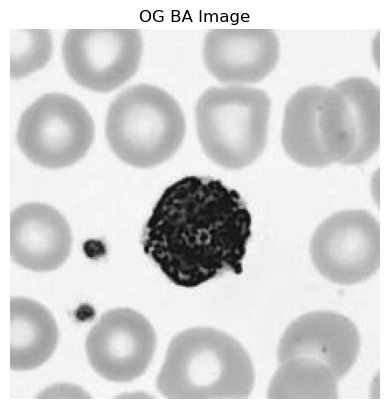

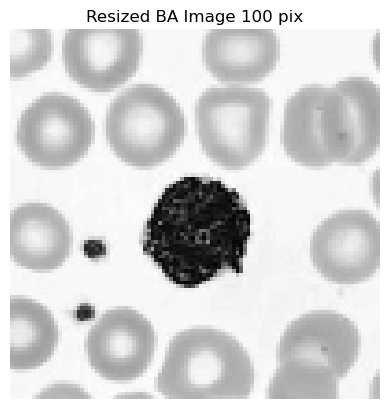

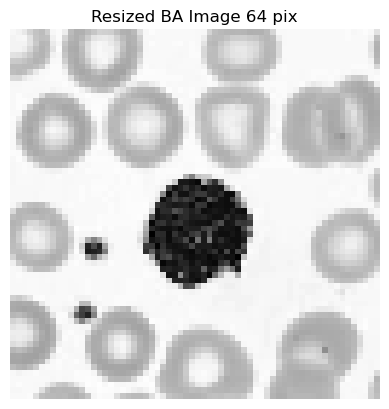

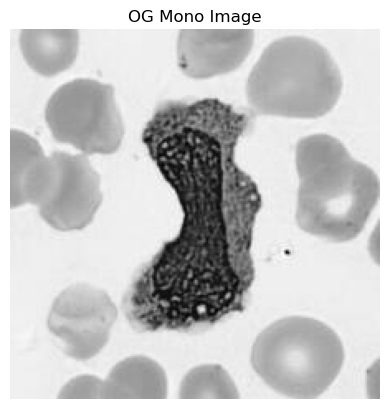

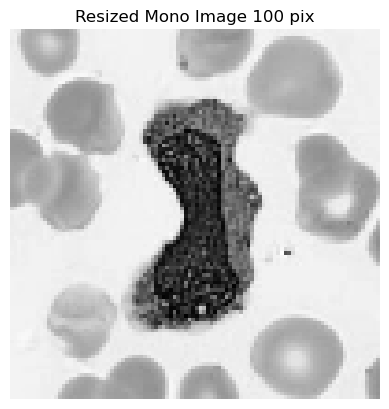

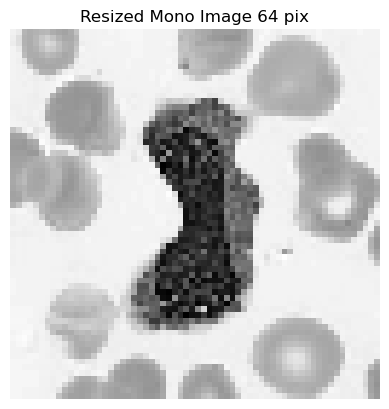

In [4]:
#load one example basophil cell image to consider how much to resize from 360x363 to consider granulocytes 
img_BA_grey = cv2.imread(('BA_100102.jpg'), cv2.IMREAD_GRAYSCALE)

rsz_BA_img_100= cv2.resize(img_BA_grey, (100, 100))

rsz_BA_img_64= cv2.resize(img_BA_grey, (64, 64))


#plot OG image
plt.imshow(img_BA_grey, cmap='gray')
plt.title('OG BA Image')
plt.axis('off')  # Hide axes
plt.show()

#plot 100 pixel image
plt.imshow(rsz_BA_img_100, cmap='gray')
plt.title('Resized BA Image 100 pix')
plt.axis('off')  # Hide axes
plt.show()


#plot 64 pixel resized image
plt.imshow(rsz_BA_img_64, cmap='gray')
plt.title('Resized BA Image 64 pix')
plt.axis('off')  # Hide axes
plt.show()


#load one example monocyte cell image to consider how much to resize from 360x363 to consider mononuclear
img_mono_grey = cv2.imread(('MO_100695.jpg'), cv2.IMREAD_GRAYSCALE)

rsz_mono_img_100= cv2.resize(img_mono_grey, (100, 100))

rsz_mono_img_64= cv2.resize(img_mono_grey, (64, 64))


#plot OG image
plt.imshow(img_mono_grey, cmap='gray')
plt.title('OG Mono Image')
plt.axis('off')  # Hide axes
plt.show()

#plot 100 pixel image
plt.imshow(rsz_mono_img_100, cmap='gray')
plt.title('Resized Mono Image 100 pix')
plt.axis('off')  # Hide axes
plt.show()


#plot 64 pixel resized image
plt.imshow(rsz_mono_img_64, cmap='gray')
plt.title('Resized Mono Image 64 pix')
plt.axis('off')  # Hide axes
plt.show()

#In conclusion, see if it can handle the 1000 pixels


## Image Pixel Information Extraction

In [5]:
#dataframe
#will appened features (pixels) further down
df = pd.DataFrame(columns=['label']) 

In [6]:
##will return the flatttened vector to add to pandas dataframe

def get_pixels(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (64, 64))
    return image.flatten()

In [7]:
%%skip
##skipping now that I read them into CV file, don't need to read in again
#Adding pixel info to dataframe
def add_to_dataframe(df, master_folder):
    for subfold in os.listdir(master_folder): #loop through all folders/categories
        subdir_path = os.path.join(master_folder, subfold) #path of subdir
        if os.path.isdir(subdir_path): #check if folder
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.jpg')):
                    full_path = os.path.join(subdir_path, filename)
                    features = get_pixels(full_path)
                    if features is not None:
                        row = {'label': subfold}  # subfolder name as label, making dictionary
                        row.update({f'pixel_{i}': val for i, val in enumerate(features)})
                        #print(row)
                        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
                        if df.shape[0] % 1000 == 0: #check if thousandth row, then print  
                            print(df.iloc[-1:])
                        
    return df

df = add_to_dataframe(df, 'PBC_dataset_normal_DIB_224')

#print(df.head())

In [8]:
%%skip
#again, already read in so can skip this now
df.to_csv('df_PBC_dataset.csv',index=False)
print(df.tail())

## Split data into training and validation

In [9]:
#now that I read the data into a csv file and have it saved there, 
#rather than calling previous code and reloading to df, I'll instead load from 
#csv into df, to hopefully save time
df = pd.read_csv('df_PBC_dataset.csv')

#encode labels....if I end up doing the spit logistic regression, I should do it here aswell
#label encoding with help of Aalto AI, need to cite assignment 2 for the plotting parts
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(df['label'])
df.insert(0, 'encoded_label', encoded_label)
#print(df).head

print("Label mapping:")
for original_label, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{original_label}: {encoded_label}")

#check that df is in correct form
#print(df['label'].head)

to_drop = ['encoded_label', 'label']

x_values = df.drop(columns=to_drop)
print(x_values.head)

# Split the dataset into a training set, validation set, and test set using two rounds of train_test_split
#the split here is 70-15-15
#y is the label
#x(i) is ith row of dataset 
#initially split to train and temp
X_train, X_temp, y_train, y_temp = train_test_split(x_values, df['encoded_label'], test_size=0.30, random_state=42)

#then split to val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
#
#check
#print(X_train.head)
#print(y_train.head)
#print(y_val.head)


Label mapping:
basophil: 0
eosinophil: 1
erythroblast: 2
ig: 3
lymphocyte: 4
monocyte: 5
neutrophil: 6
platelet: 7
<bound method NDFrame.head of        pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        232.0    228.0    220.0    203.0    190.0    185.0    199.0    232.0   
1        234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
2        193.0    192.0    195.0    204.0    228.0    234.0    232.0    231.0   
3        167.0    173.0    183.0    232.0    233.0    233.0    233.0    232.0   
4        184.0    178.0    187.0    216.0    228.0    210.0    195.0    190.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
17087    204.0    217.0    224.0    221.0    219.0    220.0    217.0    210.0   
17088    195.0    198.0    212.0    236.0    233.0    230.0    233.0    232.0   
17089    207.0    204.0    201.0    202.0    207.0    217.0    230.0    216.0   
17090    200.0    190.0    180.0    174.0    

## Now run PCA
# To figure out how many features I can reduce the dataset to.
# 

In [10]:
 
%%skip
# fit the PCA

#starting with n = 4096
N = 4096
pca_no_reduc = PCA(n_components=N)
X_train_reduced = pca_no_reduc.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(100, 40))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca_no_reduc.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=10))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca_no_reduc.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.savefig('PCA_analysis_4096')
plt.show()

#try with N = 150
N = 150
pca_150 = PCA(n_components=N)
X_train_reduced = pca_150.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(30, 10))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca_150.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=10))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca_150.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.savefig('PCA_analysis_150')
plt.show()



In [11]:
#enough to account for 95% of variance
#hoping that PCA will help to reduce the noise of the background pixels (which tend to be white and provide little helpful information
#Even though the variance between pixels tends to be low, which explains the still quite high number of 
#features needed, compared to, for example, the digits wich had much more distinct patterns
pca_95 = PCA(n_components=0.95)
X_train_reduced_95 = pca_95.fit_transform(X_train)
N = pca_95.n_components_
print(N)


819


## Training the Logistic Regression Model

In [12]:
# clf = # create the object, SET solver='sag'
clf = LogisticRegression(solver='sag' )
# fit the data
clf.fit(X_train_reduced_95,y_train)

# compute prediction on training set, to check overfitting
y_pred_train = clf.predict(X_train_reduced_95)
# y_pred = # compute the prediction on the validating set
X_trans = pca_95.transform(X_val)
y_pred = clf.predict(X_trans) 
#don't want to use fit_transform because it would learn a different transformation, need to keep consistency by projecting into same space

# multi_accuracy = # compute the accuracy score for training
multi_accuracy_training = accuracy_score(y_train, y_pred_train)

# multi_accuracy = # compute the accuracy score for validation
multi_accuracy_validation = accuracy_score(y_val, y_pred)

print(f"Prediction training accuracy: {100*multi_accuracy_training:.2f}%")
print(f"Prediction validation accuracy: {100*multi_accuracy_validation:.2f}%")




/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Prediction training accuracy: 75.79%
Prediction validation accuracy: 60.92%


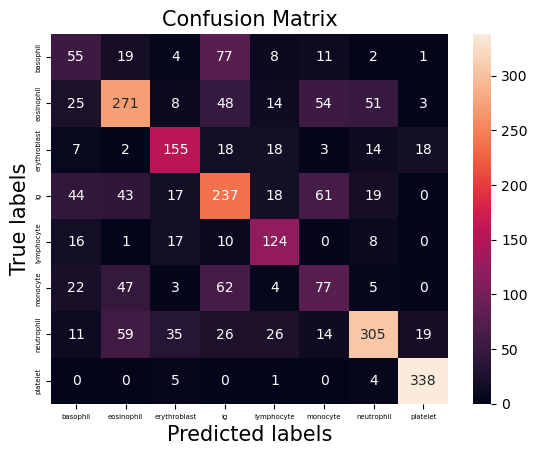

In [13]:
# visualize the confusion matrix for validation set
class_labels = label_encoder.classes_
ax = plt.subplot()
c_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=15)
ax.xaxis.set_ticklabels(class_labels, fontsize=5)
ax.yaxis.set_ticklabels(class_labels, fontsize=5)
plt.savefig('PCA_Confusion_Matrix')
plt.show()

## Second Model Neural Network

In [15]:
#this code is modeled after assignment 3

num_layers = [1,2,3,4,10,15,20,30]    # number of hidden layers, increase by order of 10 in later to see if improvements
num_neurons = [1,2,5,10,15,30,40]  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
accuracyDf = pd.DataFrame(columns=['num_layers', 'neuron_amount', 'train_accuracy', 'val_accuracy']) 

for i, num in enumerate(num_layers):
    
    for i,neur in enumerate(num_neurons):
        
        
        hidden_layer_sizes = tuple([neur]*num) # size (num of neurons) of each layer stacked in a tuple
    
        # mlp_regr = ... # Initialise an MLPClassifier
        mlp_class = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, max_iter = 1000, random_state = 42) #defaults relu
 
        # mlp_regr.fit(...,...)    # Train MLP on the training set
        mlp_class.fit(X_train_reduced_95,y_train)
    
    
        ## evaluate the trained MLP on both training set and validation set
        #I'm using accuracy instead of mean squared error
        y_pred_train = mlp_class.predict(X_train_reduced_95)    # predict on the training set
        tr_accuracy = accuracy_score(y_train, y_pred_train)    # calculate the training error
        y_pred_val = mlp_class.predict(X_trans) # predict values for the validation data 
        val_accuracy = accuracy_score(y_val, y_pred_val) # calculate the validation error
    
        
        tempDF = pd.DataFrame({
            'num_layers': [num],
            'neuron_amount': [neur],
            'train_accuracy': [tr_accuracy],
            'val_accuracy': [val_accuracy]
        })
        
        accuracyDf = pd.concat([accuracyDf, tempDF], ignore_index=True)

/tmp/ipykernel_287/1185360915.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracyDf = pd.concat([accuracyDf, tempDF], ignore_index=True)


In [17]:
print(accuracyDf)

   num_layers neuron_amount  train_accuracy  val_accuracy
0           1             1        0.362922      0.331513
1           1             2        0.590605      0.509360
2           1             5        0.770060      0.562402
3           1            10        0.892177      0.556942
4           1            15        0.950769      0.576053
5           1            30        0.999749      0.535491
6           1            40        1.000000      0.558892
7           2             1        0.336510      0.299532
8           2             2        0.540538      0.457098
9           2             5        0.732280      0.537832
10          2            10        0.823888      0.507020
11          2            15        0.966901      0.539002
12          2            30        0.998997      0.569033
13          2            40        0.919341      0.578003
14          3             1        0.197091      0.193058
15          3             2        0.613507      0.528471
16          3 

In [18]:
#read the results from varying layers and neurons into csv
accuracyDf.to_csv('PBC_NN_accuracy.csv',index=False)

# Final MLP model 15 layer, 40 neuron

In [19]:
mlp_final_class = MLPClassifier(hidden_layer_sizes = tuple([40]*15), max_iter = 1000, random_state = 42)
mlp_final_class.fit(X_train_reduced_95,y_train)

#x_trans is validation set of x through the pca
y_pred_train_mlp = mlp_final_class.predict(X_train_reduced_95)    # predict on the training set
tr_accuracy_mlp = accuracy_score(y_train, y_pred_train_mlp)    # calculate the training error
y_pred_val_mlp = mlp_final_class.predict(X_trans) # predict values for the validation data 
val_accuracy = accuracy_score(y_val, y_pred_val) # calculate the validation error
    

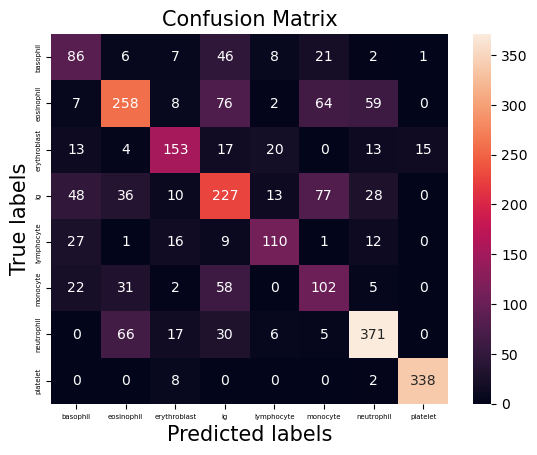

In [21]:
#confusion matrix
class_labels = label_encoder.classes_
ax = plt.subplot()
c_mat = confusion_matrix(y_val, y_pred_val_mlp)
sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=15)
ax.xaxis.set_ticklabels(class_labels, fontsize=5)
ax.yaxis.set_ticklabels(class_labels, fontsize=5)
plt.savefig('MLP_Confusion_Matrix')
plt.show()

0.6216848673946958


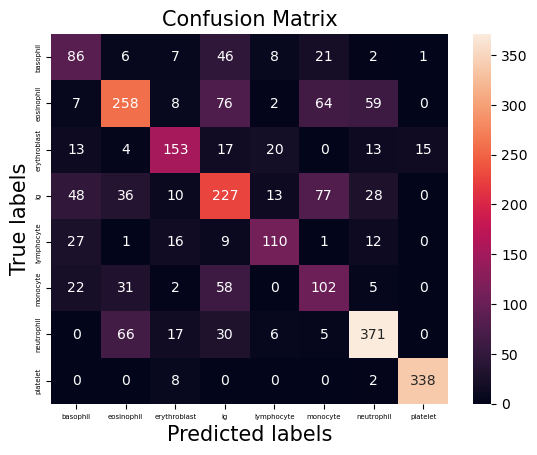

In [23]:
#test

#run through PCA
X_reduced_test = pca_95.transform(X_test)


#accuracy
y_pred_test_mlp = mlp_final_class.predict(X_reduced_test)    # predict on the test set
test_accuracy_mlp = accuracy_score(y_test, y_pred_test_mlp)    # calculate the test error
print(test_accuracy_mlp)

#confusion matrix
class_labels = label_encoder.classes_
ax = plt.subplot()
c_mat_test = confusion_matrix(y_test, y_pred_test_mlp)
sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=15)
ax.xaxis.set_ticklabels(class_labels, fontsize=5)
ax.yaxis.set_ticklabels(class_labels, fontsize=5)
plt.savefig('MLP_Confusion_Matrix_test')
plt.show()

In [25]:
from sklearn.metrics import log_loss

# Get predicted probabilities
y_prob = mlp_final_class.predict_proba(X_reduced_test)

# Compute average test loss
test_loss = log_loss(y_test, y_prob)

print(f"Average test loss (log-loss): {test_loss:.4f}")

Average test loss (log-loss): 2.6090
